In [10]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Audio, display
from ipywidgets import FileUpload, Output, HBox, VBox, Layout
from pathlib import Path

In [11]:
sounds = {1: None, 2: None} 

def handle_upload(index, change, player):
    name = change['new'][0]['name']
    content= change['new'][0]['content']
    file_path = f"samples/{name}"
    if not Path(file_path).is_file():
        with open(file_path, 'wb') as f:
            f.write(content)
            
    init_controls(index, file_path, player)


def init_controls(index, file_path, player):
    with player:
        player.clear_output()
        print(file_path)
        display(Audio(file_path))
        # Read sound array and sampling rate
        y, sr = librosa.load(file_path)
        
        # Remember file path and sound arraythe sampling rate 
        sounds[index] = (file_path, y, sr)

        fig, axis = plt.subplots(4,1)
        fig.set_size_inches(10, 20)
        plot_all(y, sr, fig, axis)
        plt.show()


def plot_all(y, sr, fig, axis):
    plot_sound(y, sr, axis[0])
    plot_spect(y, sr, fig, axis[1])    
    plot_autocorr_tempo(y, sr, fig, axis[2], axis[3])
    

def plot_sound(y, sr, ax):   
    # Plot the array
    librosa.display.waveshow(y, sr=sr, ax=ax)
    
    # Set the title and labels of the plot
    ax.set_title("Line Plot of Array")



def plot_spect(y, sr, fig, ax):
    
    # Compute the spectrogram
    spectrogram = librosa.stft(y, hop_length=1024)

    spectrogram = np.abs(spectrogram)
    
    # Convert the spectrogram to dB scale
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    # You can also visualize the spectrogram using librosa.display.specshow
    img = librosa.display.specshow(spectrogram_db, sr=sr, hop_length=1024, y_axis='log', x_axis='time', ax=ax)
    ax.set(title="Log-frequency Power Spectrogram")
    ax.label_outer()


def plot_autocorr_tempo(y, sr, fig, ax1, ax2):
    hl = 512
    onset = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hl)
    tempo = librosa.feature.tempogram(onset_envelope=onset, sr=sr, hop_length=hl)
    ax1.plot(librosa.times_like(onset), onset, label='Onset strength')
    ax1.legend(frameon=True)
    ax1.label_outer()
    librosa.display.specshow(tempo, sr=sr, hop_length=hl, x_axis='time', y_axis='tempo', cmap='magma', ax=ax2)
    ax2.set(title='Autocorrelation tempogram')

    

In [12]:
upload1, upload2 = FileUpload(multiple=False), FileUpload(multiple=False)
player1, player2 = Output(), Output()
#summary = Output()

upload1.observe(lambda ch: handle_upload(1, ch, player1), names='value')
upload2.observe(lambda ch: handle_upload(2, ch, player2), names='value')

boxes = HBox([
    VBox([upload1, player1], layout= Layout(width='50%')),
    VBox([upload2, player2], layout= Layout(width='50%'))
])

display(boxes)

# initial example
if sounds[1] is None and sounds[2] is None:
    init_controls(1, "samples/viola-son-d-min-33-38s.wav", player1)
    init_controls(2, "samples/viola-son-d-min-33-38s-2.wav", player2)

In [13]:
def calc_tempo(y, sr):
    return round(librosa.feature.tempo(y=y, sr=sr)[0], 1)


def calc_spec_center(y, sr):
    scs = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    return round(np.mean(abs(scs)))


def calc_spec_band(y, sr):
    scs = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    return round(np.mean(abs(scs)))


def compare_sounds(y1, sr1, y2, sr2):
    tempo_diff = abs(round(calc_tempo(y1, sr1) - calc_tempo(y2, sr2)))
    spec_center_diff = abs(calc_spec_center(y1, sr1) - calc_spec_center(y2, sr2))
    spec_band_diff = abs(calc_spec_band(y1, sr1) - calc_spec_band(y2, sr2))
    print(f"Tempo difference: {tempo_diff}")
    print(f"Spectral centroid difference: {spec_center_diff}")
    print(f"Spectral bandwidth difference: {spec_band_diff}")
    
if sounds[1] and sounds[2]:        
    print("Summary:")
    _, y1, sr1 = sounds[1]
    _, y2, sr2 = sounds[2]
    compare_sounds(y1, sr1, y2, sr2)

Summary:
Tempo difference: 0
Spectral centroid difference: 13
Spectral bandwidth difference: 18


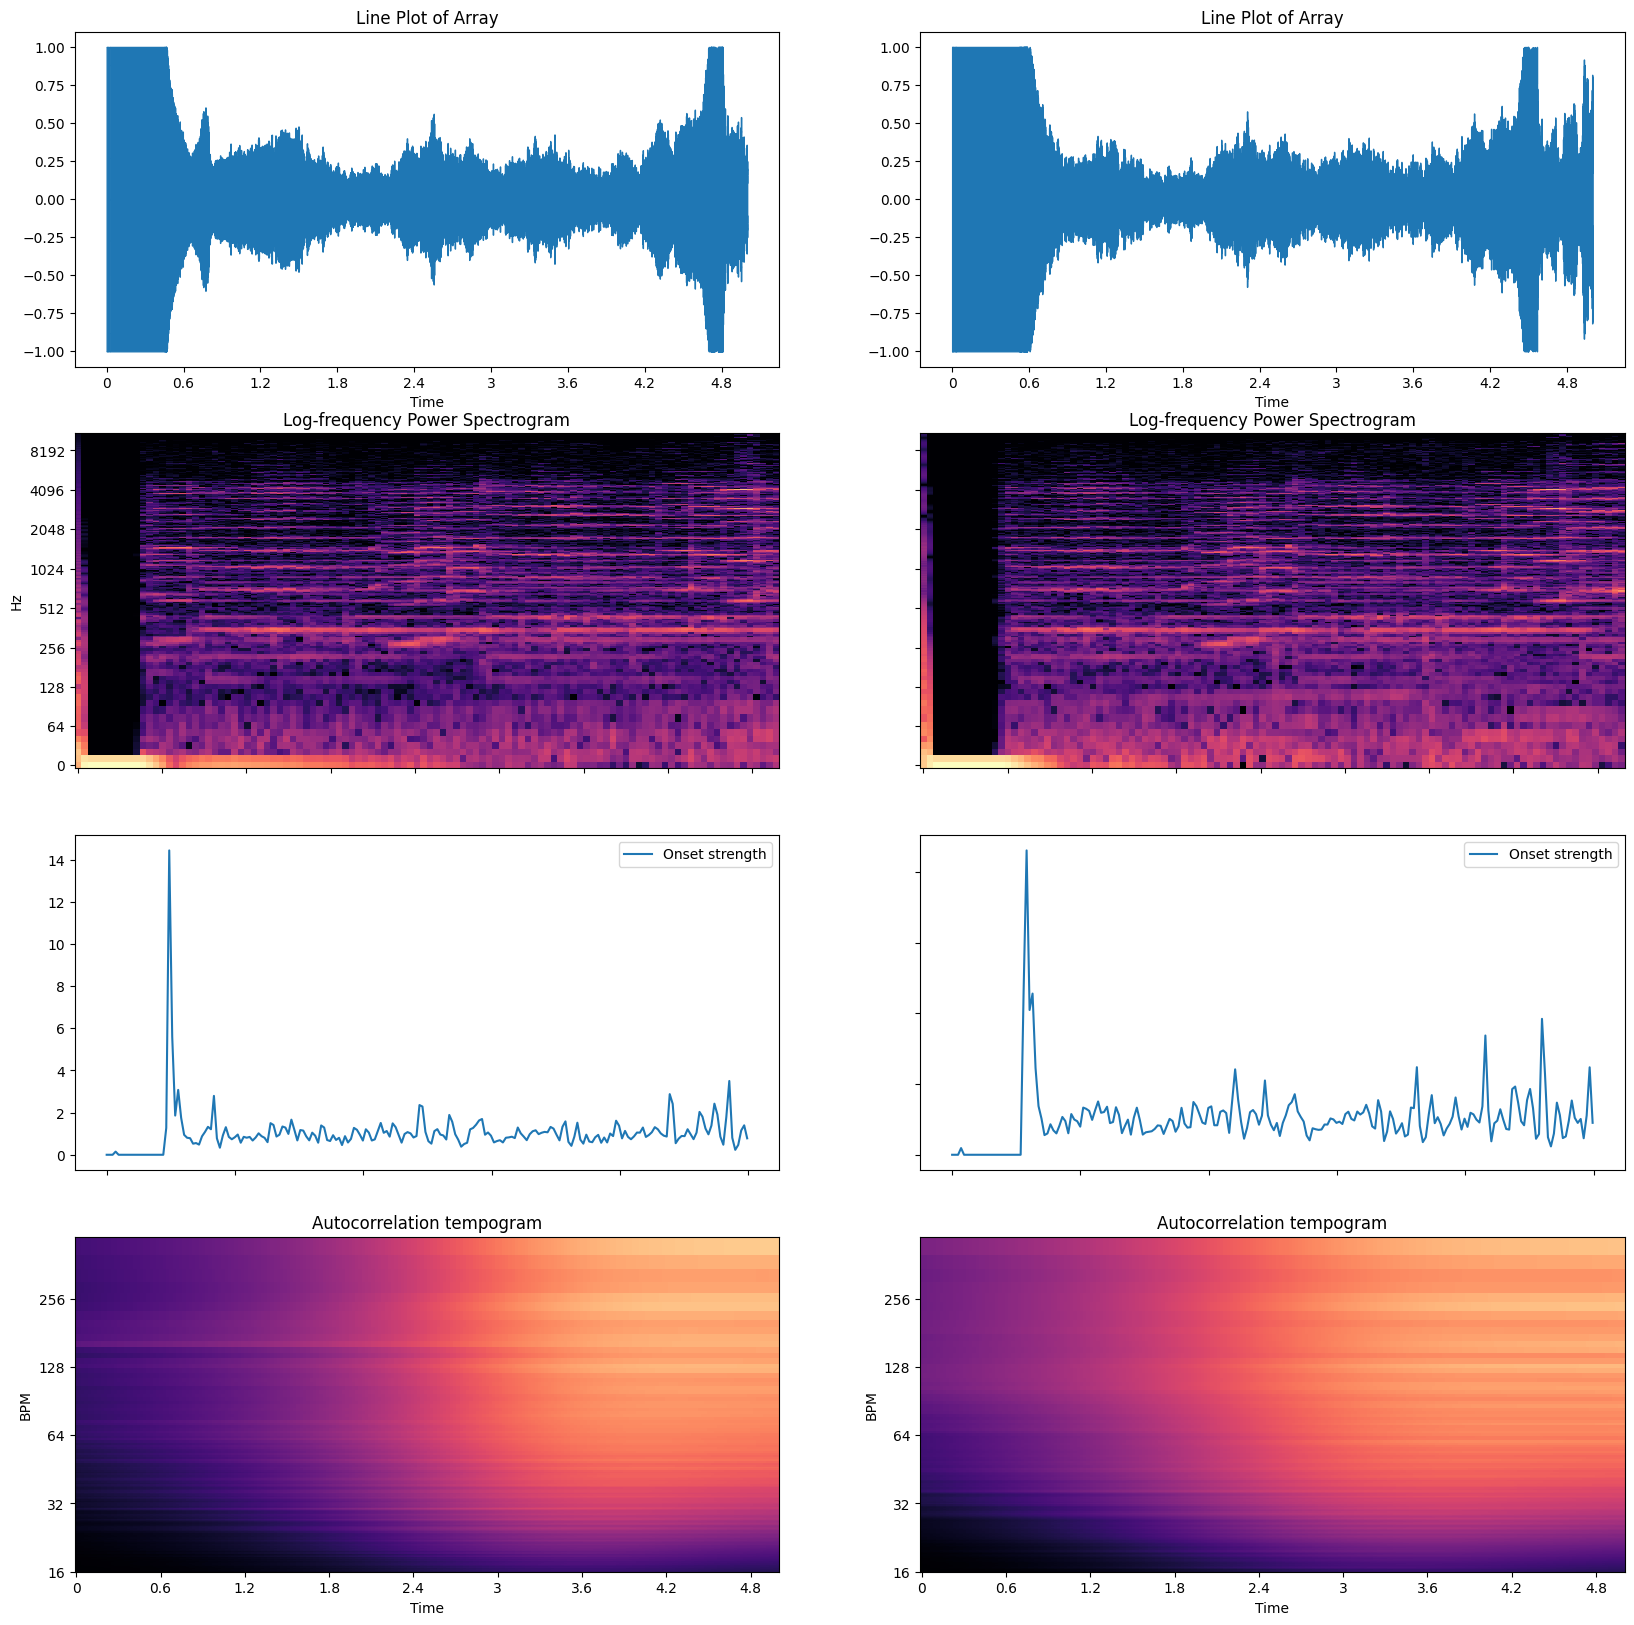

In [14]:
# Sound analysis plots (to make them visible in GitHub) 
_, y1, sr1 = sounds[1]
_, y2, sr2 = sounds[2]

fig, axis = plt.subplots(4,2)
fig.set_size_inches(20, 20)

col_axis = {0: [], 1: []}
for c in range(2):  # 0, 1
    for row in axis:
        col_axis[c].append(row[c])

plot_all(y1, sr1, fig, col_axis[0])
plot_all(y2, sr2, fig, col_axis[1])
plt.show()